#  Soil feature clustering - Kshen


## 1. Browse data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import osgeo.gdal as gdal
import numpy.ma as ma
from maxvol_cut import rect_maxvol_cut,  f_penal_2D
from tools import norm_data, add_coords, gen_input, extend_score, points_selection_accuracy, f_no_cut, f_cut_eps, calc_score, good_points_brute_force, idx_to_idx
%matplotlib inline

In [2]:
dr = '/home/apetrovskaya/Clustering/Variables_clustering_Kshen_new'
import os
fl_names = list(filter(lambda fl: fl.endswith('.tif'), os.listdir(dr)))
files = list(map(lambda x: gdal.Open(os.path.join(dr, x)), fl_names))
arrays = list(map(lambda x: x.ReadAsArray()[13:,].flatten(), files))
nodatas = list(map(lambda x: x.GetRasterBand(1).GetNoDataValue(), files))
names = list(map(lambda x: x.replace('.tif','').split('_')[0], fl_names))

FileNotFoundError: [Errno 2] No such file or directory: '/home/apetrovskaya/Clustering/Variables_clustering_Kshen_new'

In [14]:
shapes = [x.ReadAsArray().shape for x in files]
shapes

[(5108, 9164), (5108, 9164), (5108, 9164), (5108, 9164), (5108, 9164)]

In [15]:
names

['flow', 'slope', 'twi', 'cl', 'aspect']

In [16]:
dem_raw = gdal.Open('/home/apetrovskaya/Clustering/Kshen/k_3857.tif')
dem = dem_raw.ReadAsArray()
dem_flat = dem.flatten()
dem_nodata = dem_raw.GetRasterBand(1).GetNoDataValue()
init_dem_shape = dem.shape

In [17]:
#unify nodatas
# idx = np.where(arrays[3] == nodatas[3])
# arrays[3][idx] = nodatas[1]

In [18]:
idx_dem_nodata = np.where(dem_flat == dem_nodata)[0]
idx_dem = np.where(dem_flat != dem_nodata)[0]
dem_no_nodata = np.delete(dem_flat, idx_dem_nodata)
arrays_no_nodatas = np.zeros((len(dem_no_nodata), len(arrays)))

for i in range(len(arrays)):
    arrays_no_nodatas[:,i]  = np.delete(arrays[i], idx_dem_nodata)

In [19]:
#nan instead of nodatas in 3 column
# arrays_no_nodatas[:,3][arrays_no_nodatas[:,3]==nodatas[3]] = np.nan

In [20]:
data_arr = arrays_no_nodatas.copy()

## 2. Select random pixels

In [10]:
# # Select pixels with their number

# data_and_num = sorted(random.choices(list(enumerate(data_arr)), k = 50000))

In [11]:
# data =[]
# num = []
# for i in range(len(data_and_num)):
#     data.append(data_and_num[i][1])
#     num.append(data_and_num[i][0])
# data = np.asarray(data)
# num = np.asarray(num)

In [12]:
# len(data_arr) 

In [13]:
# data.shape

In [14]:
# num.shape


In [15]:
# params =[2.249928931444646, 47, 45, 7, 13.496286628463606]

## 3. Preparing data

In [21]:
# Prepare data
# U can normilize data, and/or add coords to it

mode = 3 # Change to 0, 1, 2 or 3

modes = ['tSNE_usual', 'tSNE_normed',
         'tSNE_XY', 'tSNE_XY_normed']


def gen_input(mode, data):
    fn_X_embedded = modes[mode]
    return [
        lambda x: np.array(x),
        lambda x: norm_data(x),
        lambda x: add_coords(
            x, size=init_dem_shape, idx_good_mask=idx_dem),
        lambda x: norm_data(gen_input(2, x)[0], copy=False),
    ][mode](data), fn_X_embedded


X, fn_X_embedded = gen_input(mode, data_arr)

# MaxVol

In [22]:
def points_selection_accuracy(X, n_pnts, cut_fun=None, penalty = None):
    
    """Function for selecting optimal parameters for dimentionality reduction method and for clustering.
    
    Parameters 
    ----------------
    X: array with shape (number_of_pixels*number_of_features)
            Initial data
    
    data_mode: 0,1,2,3
            Mode for preparing data.
            0 - raw data
            1 - normed data
            2 - unnormed data with coordinates as features
            3 - normed data with coordinates as feature           
 
    """
    

    n_splits = 10
    #MaxVol
    num_pnts = n_pnts
    # !!!!! It was changed !!!!!!!!!!
    # Я сделяль
    #res = rect_maxvol(X, maxK=num_pnts, minK=num_pnts)[0]
    res = rect_maxvol_cut(X, maxK=num_pnts, minK=num_pnts, cut_fun=cut_fun, penalty=penalty)[0]

    #Naive Bayes
#     gnb = GaussianNB()
#     gnb_model = gnb.fit(X[res], y[res])
#     scores = gnb_model.score(X,y)

#     print("Accuracy: %0.2f ± %0.2f" % (scores.mean(), scores.std()))
    return res

# enforce df_drop as X
def points_selection_accuracy_tail(data_mode, cut_fun=None, penalty = None):
    return points_selection_accuracy(data_arr, data_mode, cut_fun=cut_fun, penalty = f_penal)

def f_no_cut(idx, i, copy=False):
    if copy:
        idx = np.copy(idx)
    idx[i] = 0
    return idx

def f_cut_eps(idx, i, X=data_arr, eps=0.1, copy=False):
    if copy:
        idx = np.copy(idx)
    xx = X[:, -2] 
    yy = X[:, -1]   
    #idx[i] = 0
    idx[(xx - xx[i])**2 + (yy-yy[i])**2 <= eps**2] = 0
    return idx


In [23]:
data_arr

array([[2.29899096, 0.00892342, 6.16401196, 0.        , 4.21862984],
       [2.29427314, 0.00883717, 6.17167044, 0.        , 4.21955252],
       [2.30565143, 0.00874116, 6.18754196, 0.        , 4.21677208],
       ...,
       [1.18802929, 0.02748245, 5.07189083, 0.        , 4.57382965],
       [0.5438621 , 0.02534104, 4.37169552, 0.        , 4.5447464 ],
       [0.17206535, 0.02373016, 3.28657866, 0.        , 4.42073822]])

In [24]:
f_cut = lambda idx, i : f_cut_eps(idx, i, X=X, eps=0.2)
#f_penal = f_penal_2D(X = data_arr[:, -2], Y = data_arr[:, -1], bnd = 0.5, level = 1)

In [26]:
%%timeit
#without flow!
#acc_16 = points_selection_accuracy(X[:,1:], n_pnts = 16, cut_fun = None, penalty = None)[0]
res_27_with_pen = points_selection_accuracy(X, n_pnts = 16, cut_fun = f_cut, penalty = None)

6min 14s ± 1.99 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
res_16

## Visualization

In [33]:
dem_flat_img = dem_flat.copy()-np.min(dem_flat)
#dem_flat_img[np.where(dem_flat != dem_nodata)] = dem_with_clusters
dem_flat_img[np.where(dem_flat == dem_nodata)] = float('NaN')

In [253]:
idx_dem.size

32440750

In [254]:
X.shape

(32440750, 7)

In [252]:
sorted(res_27)

[8402,
 8403,
 355395,
 377171,
 905559,
 919437,
 926544,
 1526383,
 2028616,
 7455282,
 9400026,
 10539067,
 10596405,
 12433217,
 25188892,
 26718824,
 26785393,
 29112297,
 29118117,
 29123933,
 29129745,
 29221872,
 32304800,
 32304801,
 32439977,
 32440594,
 32440749]

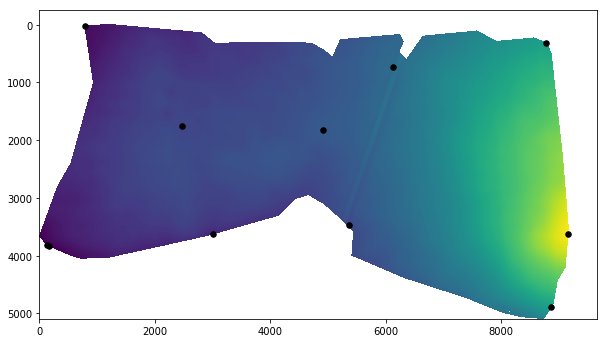

In [272]:
n=11

plt.figure(figsize=(10,10))
plt.imshow(dem_flat_img.reshape(init_dem_shape)) #, cmap = 'hsv')
XY = add_coords(size=init_dem_shape, idx_good_mask=idx_dem)
plt.scatter(XY[res_27_with_pen[:n], 0], XY[res_27_with_pen[:n], 1], s=30, color='black')
plt.savefig('kshen_maxvol.pdf'); 

In [273]:
sorted(res_27_with_pen)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8402,
 919437,
 4059197,
 12433217,
 12899907,
 26785393,
 27933939,
 27978098,
 29123933,
 29221872,
 32304801]

## Accuuracy

In [223]:
yield_raw = gdal.Open('yield.tif')
yield_ = np.mean(yield_raw.ReadAsArray(),axis=0)
yield_flat = yield_[1:,1:].flatten()

init_yield_shape = yield_.shape

In [227]:
X.shape

(32440750, 7)

In [225]:
yield_no_nodata = np.delete(yield_flat, idx_dem_nodata)
yield_no_nodata[yield_no_nodata==yield_flat[0]]=171.

In [226]:
step = (max(yield_no_nodata) - min(yield_no_nodata))/5
bins = np.arange(min(yield_no_nodata), max(yield_no_nodata), step)
y = np.digitize(yield_no_nodata,bins)

In [235]:
np.unique(y)

array([1, 2, 3, 4, 5])

In [228]:
from sklearn import svm
SVM = svm.SVR()
svm_model = SVM.fit(X[res_27[:18]], y[res_27[:18]])
svm_pred = svm_model.predict(X) 
scores = svm_model.score(X,y)

/home/apetrovskaya/anaconda3/envs/gdal/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [230]:
scores

-2.5578735729976203

In [276]:
#dem_flat_img[np.where(dem_flat != dem_nodata)] = dem_with_clusters
dem_flat_img_svm_pred= dem_flat_img.copy()
dem_flat_img_svm_pred[np.where(dem_flat != dem_nodata)]=svm_pred

dem_flat_img_y= dem_flat_img.copy()
dem_flat_img_y[np.where(dem_flat != dem_nodata)]=y

dem_flat_img_yield= dem_flat_img.copy()
dem_flat_img_yield[np.where(dem_flat != dem_nodata)]=yield_no_nodata

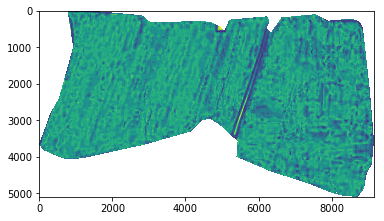

In [279]:
plt.imshow(dem_flat_img_yield.reshape(init_dem_shape))
plt.imsave('yield.tif',dem_flat_img_yield.reshape(init_dem_shape), dpi=500)

In [88]:
X.shape

(32440750, 7)

In [87]:
data_arr.shape

(32440750, 5)

In [280]:
# gnb = GaussianNB()
# gnb_model = gnb.fit(X[res_16], y[res_16])
# scores = gnb_model.score(X,y)

In [ ]:
soil_types_raw1 = pd.read_csv(os.path.join(dr, 'naive_bayes_pred.csv'), sep = ";")
soil_types_raw2 = soil_types_raw1.rename(index=str, columns={"x": "Soil_types"})
soil_types = soil_types_raw2['Soil_types'].replace(float('NaN'), global_nodata)
soil_types.index = pd.to_numeric(soil_types.index)

## Coordinates

In [35]:
xmin, ymin, xmax, ymax = [4201375.63,6781397.67,4204285.16,6783019.45]


st = dem_flat_img.reshape(init_dem_shape)

xv = np.linspace(xmin,xmax, num=st.shape[1])
yv = np.linspace(ymax,ymin, num=st.shape[0])
coords = np.meshgrid(xv,yv)

mask = idx_dem

#select corresponding points by indecies

y_c,x_c = coords[0].flatten()[mask, None],coords[1].flatten()[mask, None]
y_idx, x_idx = y_c[res_27_with_pen[:11]],x_c[res_27_with_pen[:11]]
coord_idx = np.hstack((y_idx,x_idx))

np.savetxt('coords_27_wp_kshen.csv', coord_idx, delimiter=';')

In [46]:
coord_idx

array([[4201623.93868275, 6783012.12747546],
       [4201415.95634617, 6781804.54766784],
       [4201427.70496671, 6781799.1353671 ],
       [4203080.7676296 , 6781916.61413035],
       [4202160.56486413, 6782458.79931684],
       [4204190.21844483, 6781460.38901453],
       [4204162.27577977, 6782917.57139772],
       [4203363.36958311, 6782891.14663526],
       [4202083.08747463, 6782529.79596781],
       [4201988.78098003, 6782869.81580291],
       [4204129.25263014, 6781398.6251119 ]])


## Whitebox

In [27]:
#features

from whitebox import WhiteboxTools
wbt = WhiteboxTools()

# identify the sample data directory of the package
data_dir = os.path.dirname('/home/apetrovskaya/Clustering/Kshen')

wbt.set_working_dir(data_dir)
wbt.aspect('k_3857.tif','slope_whitebox.tif')

print("\nVersion information: {}".format(wbt.version()))

names

ModuleNotFoundError: No module named 'whitebox'

## 3. Dimensionality reduction


### 2.1 TSNE

In [ ]:
np.random.seed(0)
tsne = TSNE(n_jobs=8, n_components=params[3], perplexity=params[4], random_state=0)
X_embedded = tsne.fit_transform(X)

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1) 
plt.title('TSNE', fontsize=14)

## 3. Clustering

### 3.1 DBSCAN

In [133]:
#X = df_drop.copy()

In [ ]:
dbscan = skcluster.DBSCAN(eps = params[1], min_samples = params[2])
dbscan_cluster_idx= dbscan.fit_predict(X_embedded)
col = dbscan_cluster_idx
for k in np.unique(dbscan_cluster_idx):
    plt.scatter(X_embedded[col==k, 0], X_embedded[col==k, 1], s=3)
    plt.title('TSNE colored by DBSCAN, number of clusters = '+ str(len(np.unique(dbscan_cluster_idx))) , fontsize=14)

## Visualization of the result

In [135]:
#dem_with_clusters = dem_flat_drop.copy()
#dem_with_clusters[num] = -col

In [136]:
# dem_with_points = dem_flat_drop.copy()
# dem_with_points[num[res]] = -100

In [137]:
dem_flat_img = dem_flat.copy()
#dem_flat_img[np.where(dem_flat != dem_nodata)] = dem_with_clusters
dem_flat_img[np.where(dem_flat == dem_nodata)] = float('NaN')

In [138]:
len(num)

50000

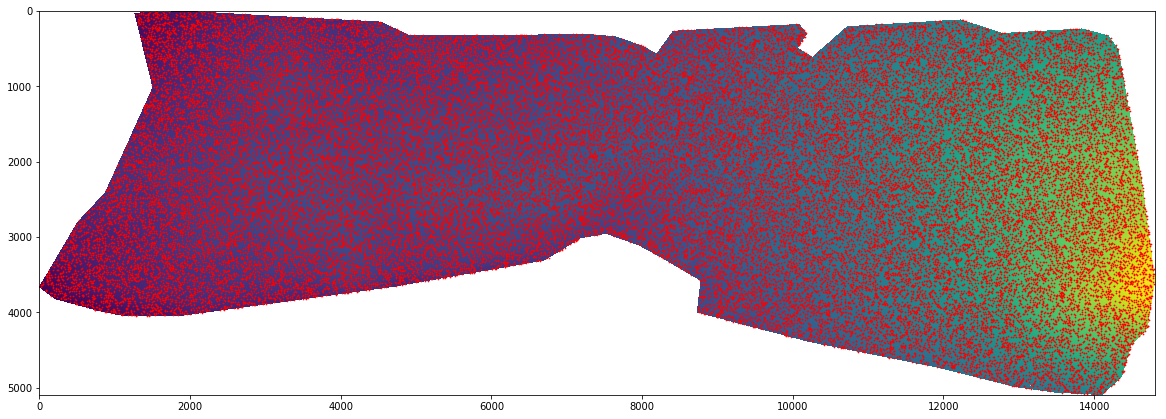

In [139]:
img = np.resize(dem_flat_img, shape)

fig = plt.figure(figsize = (20, 40))
plt.imshow(img)
plt.scatter(XY[num, 0], XY[num, 1], s=0.5, color='r')

## MaxVol

In [140]:
from maxvolpy.maxvol import rect_maxvol

In [141]:
shape

(5095, 14813)

In [142]:
X_matrix = np.asmatrix(X)

In [143]:
len(X_matrix)

50000

In [144]:
num_pnts_from_each_cluster = df_drop.shape[1]
col_uniq = np.unique(dbscan_cluster_idx)
print("Number of clusters = {}, number of points, taken from each cluster = {}".format(
    len(col_uniq), num_pnts_from_each_cluster))

idx_all = np.arange(len(dbscan_cluster_idx))
res = []

for color in col_uniq:
    idx_cur = idx_all[dbscan_cluster_idx == color]
    
    if len(X_matrix[idx_cur]) < 5:
        continue  # Skip this cluster for now
        
    if np.linalg.matrix_rank(X_matrix[idx_cur]) < X_matrix.shape[1]:
        res.append(idx_cur[0])
        continue  # Skip this cluster for now
        
    idx_mv = rect_maxvol(
        X_matrix[idx_cur], maxK=num_pnts_from_each_cluster, minK=num_pnts_from_each_cluster)[0]
    res.extend(idx_cur[idx_mv])

Number of clusters = 1, number of points, taken from each cluster = 5


In [145]:
# In res we have only indices, convert them to coords
fig = plt.figure(figsize = (20, 40))
dem_flat_2 = dem_flat.copy()
dem_flat_2[np.where(dem_flat == dem_nodata)] = float('NaN')

<Figure size 1440x2880 with 0 Axes>

In [146]:
num[res]

array([859])

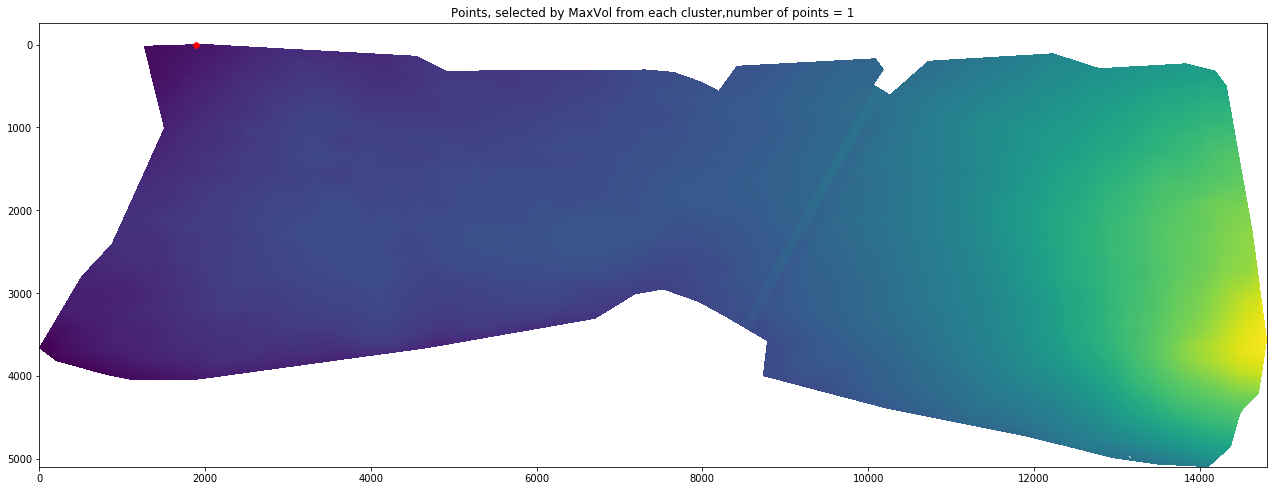

In [147]:
plt.figure(figsize=(22, 22))
plt.imshow(dem_flat_2.reshape(shape));
XY = add_coords(size=shape, idx_good_mask= df_drop['slope'].index.values)
plt.scatter(XY[num[res], 0], XY[num[res], 1], s=30, color='r'); 
plt.title('Points, selected by MaxVol from each cluster,number of points = '+str(len(res)));

### Use usual MaxVol to set nodes, using clustering as a layer

In [148]:
dbscan_cluster_idx = np.reshape(dbscan_cluster_idx, (dbscan_cluster_idx.shape[0],1))
X_with_clusters = np.concatenate((X_matrix, dbscan_cluster_idx), axis =1)
#X_with_clusters_XY = add_coords(X_with_clusters, size=shape, idx_good_mask= df_drop['slope'].index.values)

In [149]:
X_with_clusters_arr = np.asarray(X_with_clusters)

In [153]:
num_pnts = X_with_clusters.shape[1]
num_pnts = 50
res = rect_maxvol(X_with_clusters_arr, maxK=num_pnts, minK=num_pnts)[0]

ValueError: Input matrix must not be singular

In [155]:
print(X_with_clusters_arr.shape)
np.linalg.matrix_rank(X_with_clusters_arr)

(50000, 8)


6

In [171]:
for i in range(0, 6):
    print (i)
    Xtest =np.hstack((X_with_clusters_arr[:, i:i+1], X_with_clusters_arr[:, -2:]))
    print(Xtest.shape)
    print("rank =", np.linalg.matrix_rank(Xtest))

print("rank =", np.linalg.matrix_rank(X_with_clusters_arr[:, -2:]))


0
(50000, 3)
rank = 2
1
(50000, 3)
rank = 2
2
(50000, 3)
rank = 2
3
(50000, 3)
rank = 2
4
(50000, 3)
rank = 2
5
(50000, 3)
rank = 2
rank = 1


In [177]:
min(X_with_clusters_arr[:, -2:-1])

array([-1.])

In [179]:
shape[0]*shape[1]

75472235

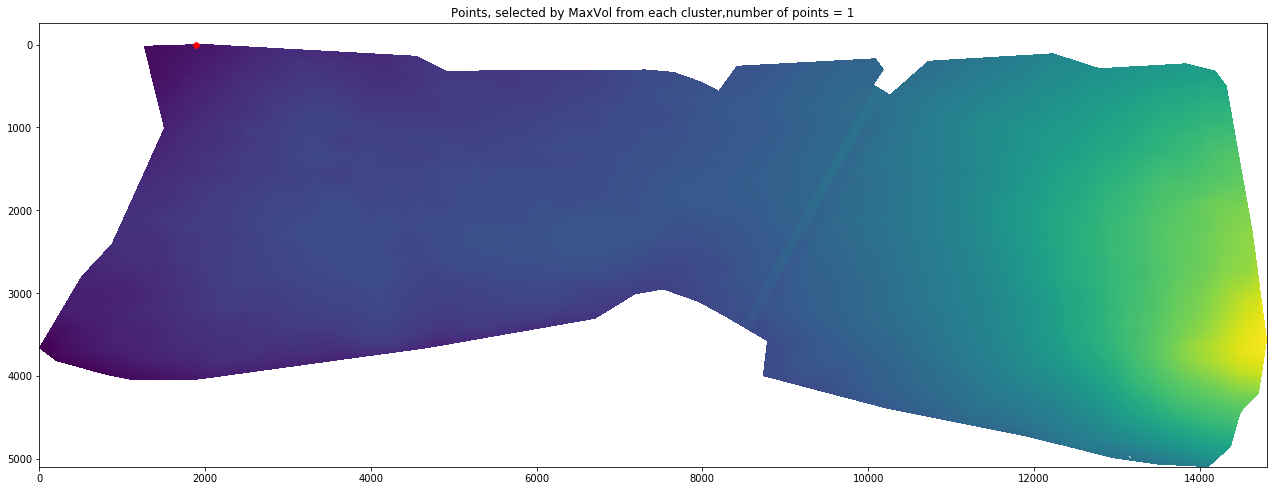

In [152]:
# In res we have only indices, convert them to coords
plt.figure(figsize=(22, 22))
plt.imshow(dem_flat_2.reshape(shape));
XY = add_coords(size=shape, idx_good_mask= df_drop['slope'].index.values)
plt.scatter(XY[num[res], 0], XY[num[res], 1], s=30, color='r'); 
plt.title('Points, selected by MaxVol from each cluster,number of points = '+str(len(res)));

### Experiment with superpixels